# IMDB Movie Reviews Sentiment Analysis
This notebook performs sentiment analysis on the IMDB 50k movie reviews dataset. It covers data ingestion, preprocessing, vectorization, and model training using XGBoost.

## 1. Data Ingestion
In this section, we download the dataset using `kagglehub` and load it into a Pandas DataFrame.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

100%|██████████| 25.7M/25.7M [00:01<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: C:\Users\abano\.cache\kagglehub\datasets\lakshmi25npathi\imdb-dataset-of-50k-movie-reviews\versions\1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [6]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [33]:
X, y = df[['review']], df.sentiment
y.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## 2. Text Preprocessing
We clean the raw text by removing punctuation and stop words. We also apply tokenization, stemming, and lemmatization using a custom utility class `NLP_utils`.

In [34]:
from NLP_utils import NLP_utils

nlp = NLP_utils()

X['review_nopunc'] = X['review'].apply(lambda x: nlp.remove_punc(str(x)))
X['review_tokens'] = X['review_nopunc'].apply(lambda x: nlp.tokenize(x))
X['review_nonstop'] = X['review_tokens'].apply(lambda x: nlp.remove_stopwords(x))
X['review_stemming'] = X['review_nonstop'].apply(lambda x: nlp.stemming(x))
X['review_lemmatizing'] = X['review_nonstop'].apply(lambda x: nlp.lemmatizing(x))
X['review_processed'] = X['review_lemmatizing'].apply(lambda x: ' '.join(x))

X

,review,review_nopunc,review_tokens,review_nonstop,review_stemming,review_lemmatizing,review_processed
0,One of the other reviewers has mentioned that ...,One of the other reviewers has mentioned that ...,"[One, of, the, other, reviewers, has, mentione...","[One, reviewers, mentioned, watching, 1, Oz, e...","[one, review, mention, watch, 1, oz, episod, y...","[One, reviewer, mentioned, watching, 1, Oz, ep...",One reviewer mentioned watching 1 Oz episode y...
1,A wonderful little production. <br /><br />The...,A wonderful little production br br The filmin...,"[A, wonderful, little, production, br, br, The...","[A, wonderful, little, production, br, br, The...","[a, wonder, littl, product, br, br, the, film,...","[A, wonderful, little, production, br, br, The...",A wonderful little production br br The filmin...
2,I thought this was a wonderful way to spend ti...,I thought this was a wonderful way to spend ti...,"[I, thought, this, was, a, wonderful, way, to,...","[I, thought, wonderful, way, spend, time, hot,...","[i, thought, wonder, way, spend, time, hot, su...","[I, thought, wonderful, way, spend, time, hot,...",I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,Basically theres a family where a little boy J...,"[Basically, theres, a, family, where, a, littl...","[Basically, theres, family, little, boy, Jake,...","[basic, there, famili, littl, boy, jake, think...","[Basically, there, family, little, boy, Jake, ...",Basically there family little boy Jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",Petter Matteis Love in the Time of Money is a ...,"[Petter, Matteis, Love, in, the, Time, of, Mon...","[Petter, Matteis, Love, Time, Money, visually,...","[petter, mattei, love, time, money, visual, st...","[Petter, Matteis, Love, Time, Money, visually,...",Petter Matteis Love Time Money visually stunni...
...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,I thought this movie did a down right good job...,"[I, thought, this, movie, did, a, down, right,...","[I, thought, movie, right, good, job, It, wasn...","[i, thought, movi, right, good, job, it, wasnt...","[I, thought, movie, right, good, job, It, wasn...",I thought movie right good job It wasnt creati...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",Bad plot bad dialogue bad acting idiotic direc...,"[Bad, plot, bad, dialogue, bad, acting, idioti...","[Bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogu, bad, act, idiot, dir...","[Bad, plot, bad, dialogue, bad, acting, idioti...",Bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,I am a Catholic taught in parochial elementary...,"[I, am, a, Catholic, taught, in, parochial, el...","[I, Catholic, taught, parochial, elementary, s...","[i, cathol, taught, parochi, elementari, schoo...","[I, Catholic, taught, parochial, elementary, s...",I Catholic taught parochial elementary school ...
49998,I'm going to have to disagree with the previou...,Im going to have to disagree with the previous...,"[Im, going, to, have, to, disagree, with, the,...","[Im, going, disagree, previous, comment, side,...","[im, go, disagre, previou, comment, side, malt...","[Im, going, disagree, previous, comment, side,...",Im going disagree previous comment side Maltin...


In [42]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y = encoder.fit_transform(y)

## 3. Feature Extraction
The processed reviews are converted into numerical features using **TF-IDF Vectorization** with a maximum of 5,000 features.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X['review_processed'])

## 4. Model Training and Evaluation
We split the data into training, evaluation, and test sets. A **Logistic Regression** & **XGBoost Classifier** are trained to predict the sentiment (positive/negative).

In [43]:
from sklearn.model_selection import train_test_split

X_train_eval, X_test, y_train_eval, y_test = train_test_split(X_tfidf, y, stratify=y, random_state=42, test_size=.20)
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval, y_train_eval, stratify=y_train_eval, random_state=42, test_size=.20)

89.07 %


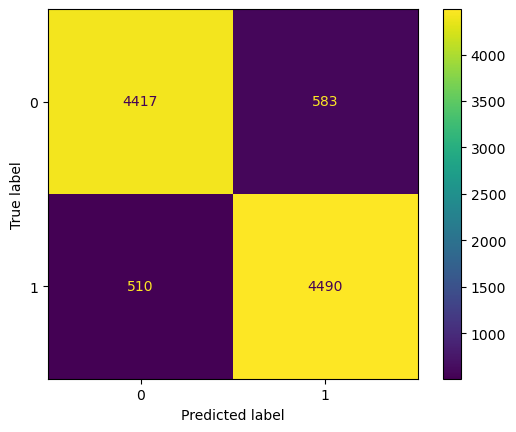

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Lr = LogisticRegression().fit(X_train, y_train)

y_pred = Lr.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"{acc*100:.2f} %")
ConfusionMatrixDisplay(cm).plot()

83.59 %


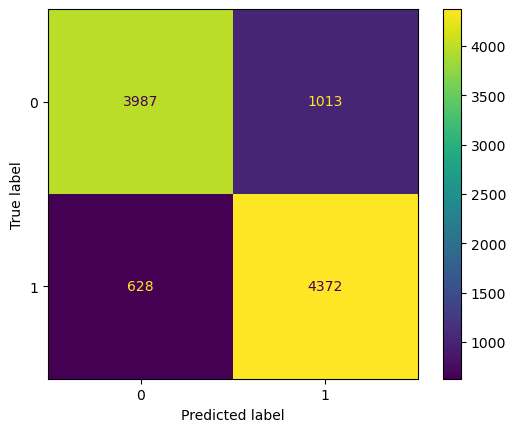

In [48]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
).fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=False)


y_pred = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"{acc*100:.2f} %")
ConfusionMatrixDisplay(cm).plot()